# COWI Client feedback finder from email

### Objective: 

The objective of this job is to find customer feedback/client feedback and label them automatically. I propose to use Natural Language Processing methods using Deep Learning to build a prediction model.

### Dataset:

Emails exported from outlook using email export to csv format.

In [1]:
#Random seed for reproducibility and import basic packages
import numpy as np
import pandas as pd
np.random.seed(42)

### Read the dataset

In [2]:
local_path='C:/SKCY/Python/COWI/'
email_df=pd.read_excel(local_path+'email_feedback.xlsx',sheetname='tags')

### How does the dataset look like:

In [26]:
email_df[['Body','Feedback']].head(10)

,Body,Feedback
0,Dear Sayak\r\n\r\n \r\n\r\nI would like to dis...,NaN
1,Dear Sayak\r\n\r\n \r\n\r\nMy team completed t...,1.0
2,Dear Sayak\r\n\r\n \r\n\r\nYou must compile th...,NaN
3,"Dear Sayak\r\n\r\n \r\n\r\nTomorrow, I will se...",NaN
4,Dear Sayak\r\n\r\n \r\n\r\nIn attached the fin...,NaN
5,\r\n,NaN
6,Dear Sayak\r\n\r\n \r\n\r\nIn attached the lis...,NaN
7,"Dear Sayak\r\n\r\n \r\n\r\nPlease, see below m...",NaN
8,Dear Sayak\r\n\r\n \r\n\r\nTomorrow complete o...,NaN
9,"Dear Sayak\r\n\r\n \r\n\r\nPlease, let me know...",NaN


In [27]:
print('Number of emails:',email_df.shape[0])

Number of emails: 2583


In [28]:
#drop row that does not have any thing in body
email_df.Body.fillna(' ',inplace=True)

### Let us see the body of first email

In [30]:
email_df.Body[2]

'Dear Sayak\r\n\r\n \r\n\r\nYou must compile these urban regions within the precision of the mapping 10,000.\r\n\r\n \r\n\r\nRegarding the example you have not need to compile this amount of breaklines, as long as the accuracy of the DTM is within specification standards 10,000.\r\n\r\n \r\n\r\nThere is not possibility to be considered these areas as 1,000 mapping scale. Does not make sense...\r\n\r\n \r\n\r\nBest regards\r\n\r\nDenis\r\n\r\n \r\n\r\nDe: Manuj Dev [mailto:madv@cowi.com] \r\nEnviada em: quarta-feira, 15 de novembro de 2017 12:15\r\nPara: Denis Silva; Sayak Chakraborty\r\nCc: A099730_Mail; Vinod Kumar Mahindru\r\nAssunto: RE: UR Project - dense mapping in 10000 scale\r\nPrioridade: Alta\r\n\r\n \r\n\r\nDear Denis:\r\n\r\n \r\n\r\nWe have encountered an area in Block 11 which is complete dense town of approx.. 74 sqkm. The area details are there in the attached KMZ file.\r\n\r\n \r\n\r\nThe sample data from the area is as shown below:\r\n\r\n \r\n\r\n\r\n\r\n \r\n\r\nWe a

#### Observation:
Problem while exporting the email from inbox is it takes all the chain/trail emails, but only the first part of the email might be relevant for feedback, hence some text processing is required.

### Data Cleaning

Let us write a function to clean and extract important portion of the email

### Feedback email extraction function

In [31]:
# import regular expression package
import re

# define delimeters for 1st email to 2nd email for case of chain email
delim=['de:','<', 'from:', 'best regards,', 'best regard,', 'thanks,', 'thank you,', 'regards,', '|', 'kind regards']

# function to clean and take relevant portion of latest email
def clean_str(string1):
    string1=re.sub('\r\n',' ',string1).lower()       # replace \r\n
    for i in delim:                              # loop over all delimeters
        string1=string1.split(i)
        string1=string1[0]
    string1=re.sub(r'[^A-Za-z]'," ",string1)     # Keep alpha characters only, special and numeric 
    words = string1.strip().lower().split()      # split the sentence to word
    words = [w for w in words if len(w)>=1]      # keep greater than one character words
    return " ".join(words)                       # joins them to form sentence
    #return string1

In [32]:
#apply the functions on dataframe 

#feedback email
email_df['cleaned_body']=email_df.Body.apply(clean_str)

#### Let us see how the email looks like now

In [33]:
print('Email body:\n',email_df.cleaned_body[2])
print('\nFeedback reponse:',email_df.Feedback[2])

Email body:
 dear sayak you must compile these urban regions within the precision of the mapping regarding the example you have not need to compile this amount of breaklines as long as the accuracy of the dtm is within specification standards there is not possibility to be considered these areas as mapping scale does not make sense best regards denis

Feedback reponse: nan


#### Observation: 
The column feedback contains values 1 if the email is labeled as client feedback, the non feedback emails do not have any label, let us populate them with zero(0)

In [34]:
#fill null values with 0
email_df['Feedback']=email_df.Feedback.fillna(0)

In [35]:
#see the data now
#email_df.head(2)

In [36]:
email_df.groupby('Feedback').count()['Body']

Feedback
0.0    2414
1.0     169
Name: Body, dtype: int64

## Let us now design the Feedback prediction model

We shall use TFIDF mode= Term Frequency Inverse Document Frequency

### Term frequency
In the case of the term frequency tf(t,d), the simplest choice is to use the raw count of a term in a document

### Inverse document frequency
The inverse document frequency is a measure of how much information the word provides, i.e., if it's common or rare across all documents. 

#### Let us split the data in train and test

In [37]:
#import train and test split module
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test=train_test_split(email_df['cleaned_body'],email_df['Feedback'],
                                                 test_size=0.2, random_state=42)

#### Build TFIDF vector

In [38]:
#import keras tokenizer class
from keras.preprocessing.text import Tokenizer

top_words=5000
t=Tokenizer(top_words)

t.fit_on_texts(X_train.tolist())

#Build TFIDF
X_train=t.texts_to_matrix(X_train.tolist(),mode='tfidf')
X_test=t.texts_to_matrix(X_test.tolist(),mode='tfidf')


Using TensorFlow backend.


In [39]:
print(X_train[2])

[0.        0.        1.2565791 ... 0.        0.        0.       ]


## Building the graph

In [40]:
#import Sequential model
from keras.models import Sequential
#import layers for the model
from keras.layers import Dense,Dropout,BatchNormalization

from keras.callbacks import ModelCheckpoint,TensorBoard

#build a sequential model
model=Sequential()

####  Add the Deep Dense Layer

In [41]:
#model.add(BatchNormalization())
model.add(Dense(400,activation='tanh',input_shape=(5000,)))
#model.add(BatchNormalization())
model.add(Dense(200,activation='tanh'))
#model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(60,activation='tanh'))
#model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(20,activation='tanh'))
#model.add(BatchNormalization())
model.add(Dense(1,activation='sigmoid'))


model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

#### Model checkpoint

In [42]:
checkpoint=ModelCheckpoint('C:/SKCY/Python/COWI/COWI_feedback_email_tfidf_test.hdf5',monitor='val_acc',
                           mode='max',save_best_only=True,verbose=1)
#my_callbacks = [EarlyStopping(monitor='auc_roc', patience=300, verbose=1, mode='max')]

#### Set weight to the classes (Change from baseline0)

In [43]:
class_wgt={0.0:0.05,1.0:0.95}

### Execute the graph

In [44]:
model.fit(X_train,y_train,batch_size=256,epochs=30,validation_data=[X_test,y_test],class_weight=class_wgt,
          callbacks=[checkpoint,TensorBoard(log_dir='C:/SKCY/Python/COWI/')])

#model.fit(X_train,y_train,batch_size=128,epochs=10,validation_data=[X_test,y_test],
          #callbacks=my_callbacks)

Train on 2066 samples, validate on 517 samples
Epoch 1/30
2066/2066 [==============================] - 1s 707us/step - loss: 0.0501 - acc: 0.7304 - val_loss: 0.3851 - val_acc: 0.8549

Epoch 00001: val_acc improved from -inf to 0.85493, saving model to C:/SKCY/Python/COWI/COWI_feedback_email_tfidf_test.hdf5
Epoch 2/30
2066/2066 [==============================] - 1s 499us/step - loss: 0.0160 - acc: 0.9269 - val_loss: 0.1370 - val_acc: 0.9555

Epoch 00002: val_acc improved from 0.85493 to 0.95551, saving model to C:/SKCY/Python/COWI/COWI_feedback_email_tfidf_test.hdf5
Epoch 3/30
2066/2066 [==============================] - 1s 490us/step - loss: 0.0087 - acc: 0.9773 - val_loss: 0.1458 - val_acc: 0.9497

Epoch 00003: val_acc did not improve from 0.95551
Epoch 4/30
2066/2066 [==============================] - 1s 481us/step - loss: 0.0060 - acc: 0.9811 - val_loss: 0.1272 - val_acc: 0.9594

Epoch 00004: val_acc improved from 0.95551 to 0.95938, saving model to C:/SKCY/Python/COWI/COWI_feedback

### Predict on test data

In [45]:
y_pred=model.predict(X_test)

In [21]:
#y_test[100:120]

In [22]:
#y_pred[100:120]

#### Check for threshold

In [53]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

for i in range (10,50,6):
    y_pred_n=np.where(y_pred>i/100,1,0)
    print('Probablistic threshold:',i/100)
    print(confusion_matrix(y_test,y_pred_n))  
    

Probablistic threshold: 0.1
[[476  14]
 [  8  19]]
Probablistic threshold: 0.16
[[476  14]
 [  8  19]]
Probablistic threshold: 0.22
[[476  14]
 [  8  19]]
Probablistic threshold: 0.28
[[476  14]
 [  8  19]]
Probablistic threshold: 0.34
[[476  14]
 [  8  19]]
Probablistic threshold: 0.4
[[476  14]
 [  8  19]]
Probablistic threshold: 0.46
[[476  14]
 [  8  19]]


In [47]:
#Thershold of 0.4 looks good
y_pred=np.where(y_pred>0.4,1,0)

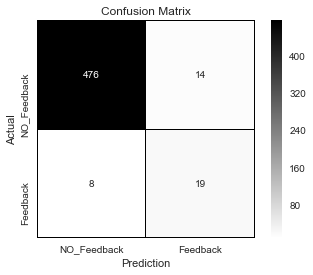

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(y_test,y_pred),linecolor='black',linewidths=0.1,fmt='d',annot=True,square=True,cmap='gray_r',
            yticklabels=['NO_Feedback','Feedback'],xticklabels=['NO_Feedback','Feedback'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [52]:
accuracy_score(y_pred,y_test)

0.9574468085106383

In [57]:
print('Classification report:\n',classification_report(y_pred,y_test))

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.98      0.98       484
          1       0.70      0.58      0.63        33

avg / total       0.95      0.96      0.96       517



#### Dump the Tokenizer function for further prediction

In [50]:
import pickle
pickle.dump(t,open('C:/SKCY/Python/COWI/text_tokenizer_test.hdf5','wb'))

### Conclusion: 
In the above work the purpose is to find best possible Feedback emails, so our focus will be to improve recall score of class-1. At this moment TDIDF with Tanh activation for dense layers looks good with probability>0.4, We have also applied class weights to handle imbalance in dataset.

In next notebook I shall try doing feature engineering and stacking up models to explore if we can obtain better than this baseline prediction. 
